# Part A Convolution Neural Networks
| Name                  | Admin No. | Class          |
| --------------------- | --------- | -------------- |
| Ernest Ng Sheng Kang  | P2222668  | DAAA/FT/2B/06  |
## Background Infomation



## Initializing Libaries

In [44]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from sklearn.metrics import classification_report
from keras.utils import to_categorical
import keras_tuner as kt
import visualkeras
from keras.regularizers import l1, l2
from keras.layers import AveragePooling2D, ZeroPadding2D, BatchNormalization, Activation, MaxPool2D, Add
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Normalization, Dense, Conv2D, Dropout, BatchNormalization, ReLU
from keras.models import Sequential
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import Input
from keras.optimizers import *
from keras.callbacks import EarlyStopping

## Checking GPU

In [45]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Fixing random seed

In [46]:
seed = 69
np.random.seed(seed)

## factors to consider/research

- overfitting (how to prevent it)
    - data augmentation
    - L1 and L2 regulazation
    - dropout layers
    - 
- how does the various parameter of a model (dense layers, parameters of dense layers, activation fucntions, optimizers, learning rate, weigh initilzation, et...)
- affect it eg its accuracy and how does it learn/ will it have vanishing gradient / exploding gradient or any other problems?
- training time and efficiency
    - batch size
- 

## Problem statement
Our problem for this assignment is to create a deep learning model to predict vegatables using the dataset on vegatables.

We need to create 2 seperate final models to predict images on 2 different input sizes:
- 31 x 31
- 128 x128 

## Goals of this project
### Generalise to data well
> To make sure our model is able to generalise to data well, we need to __minimize__ the difference between our training accuracy and test accuracy.
### Accuracy
> In order to minimize avoidable bias, it is important for the model to achieve a training set accuracy of at least __85%__ or higher, which signifies a reasonable level of accuracy.

# Importing Datasets

In [97]:
directory_train = './datasets/Dataset for CA1 part A/train'
directory_test = './datasets/Dataset for CA1 part A/test'
directory_validation = './datasets/Dataset for CA1 part A/validation'

def dataset(directory,image_size,seed=seed,batch_size=64):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='categorical',
        color_mode='grayscale',
        image_size=image_size,
        shuffle=True,
        seed=seed,
        batch_size=batch_size
    )
    return dataset


In [98]:
dataset_train_31 = dataset(directory_train,(31,31))
dataset_test_31 = dataset(directory_test,(31,31))
dataset_validation_31 = dataset(directory_validation,(31,31))

dataset_train_128 = dataset(directory_train,(128,128))
dataset_test_128 = dataset(directory_test,(128,128))
dataset_validation_128 = dataset(directory_validation,(128,128))

Found 9028 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 9028 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


## EDA
What can we get from our EDA?
- How does the average image look like for each class?
- How is the class distribution?
- How does a sample image look like for each class?


In [49]:
class_labels = [
    "Bean",
    "Bitter Gourd",
    "Bottle Gourd",
    "Brinjal",
    "Broccoli",
    "Cabbage",
    "Capsicum",
    "Carrot",
    "Cauliflower",
    "Cucumber",
    "Papaya",
    "Potato",
    "Pumpkin",
    "Radish",
    "Tomato",
]

In [50]:
for images, labels in dataset_train_31.take(1):
    print("31x31 Batch Shape:", images.shape)
for images, labels in dataset_train_128.take(1):
    print("128x128 Batch Shape:", images.shape)

31x31 Batch Shape: (9028, 31, 31, 1)
128x128 Batch Shape: (9028, 128, 128, 1)


Our image shapes are 31x31 and 128x128, with a single colour channel.

We have a default batch size of 64, since tf.keras.preprocessing.image_dataset_from_directory requires a default batch size or else the model wont fit properly. Fortunatly we can set our batch size again when we fit our models.

### Visualizing our datasets

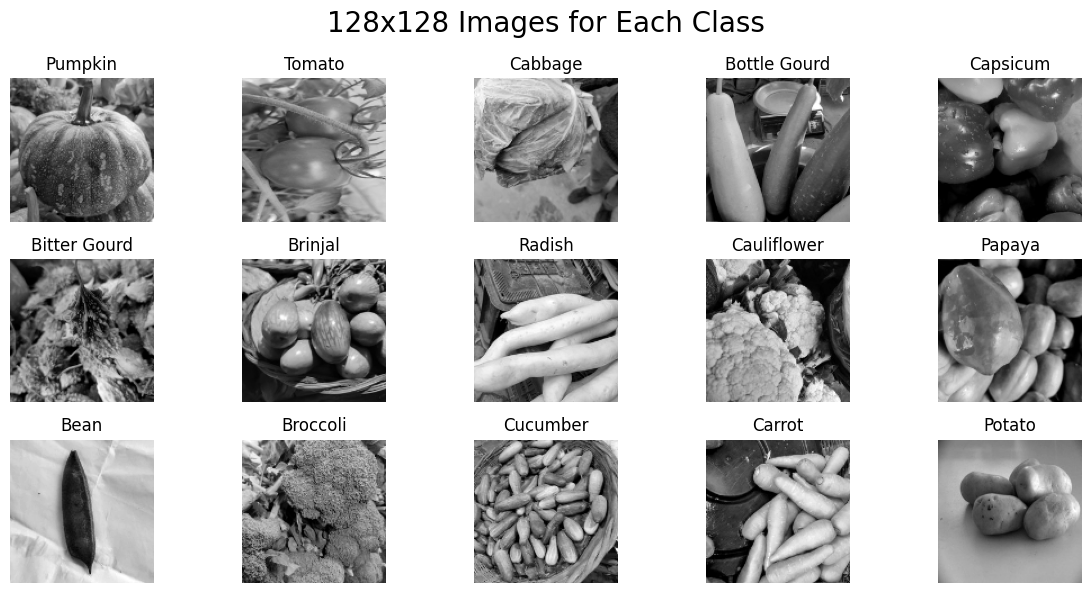

In [51]:
def plot_unique_images(dataset, title, class_labels):
    plt.figure(figsize=(12, 6))
    plt.suptitle(title, fontsize=20)
    unique_images = []  
    unique_labels = []  

    #get unique images
    for images, labels in dataset:
        for i, label in enumerate(labels):
            label_idx = tf.argmax(label).numpy()
            if label_idx not in unique_labels:
                unique_images.append(images[i].numpy().astype("uint8"))
                unique_labels.append(label_idx)

            if len(unique_images) == len(class_labels):
                break 
        if len(unique_images) == len(class_labels):
            break  

    num_images = len(unique_images)
    row = int(np.sqrt(num_images))
    col = int(np.ceil(num_images / row))

    for i in range(num_images):
        ax = plt.subplot(row, col, i + 1)
        plt.imshow(unique_images[i], cmap='gray')
        plt.title(class_labels[unique_labels[i]])
        plt.axis("off")

    plt.tight_layout()
    plt.show()

plot_unique_images(dataset_train_128, '128x128 Images for Each Class', class_labels)

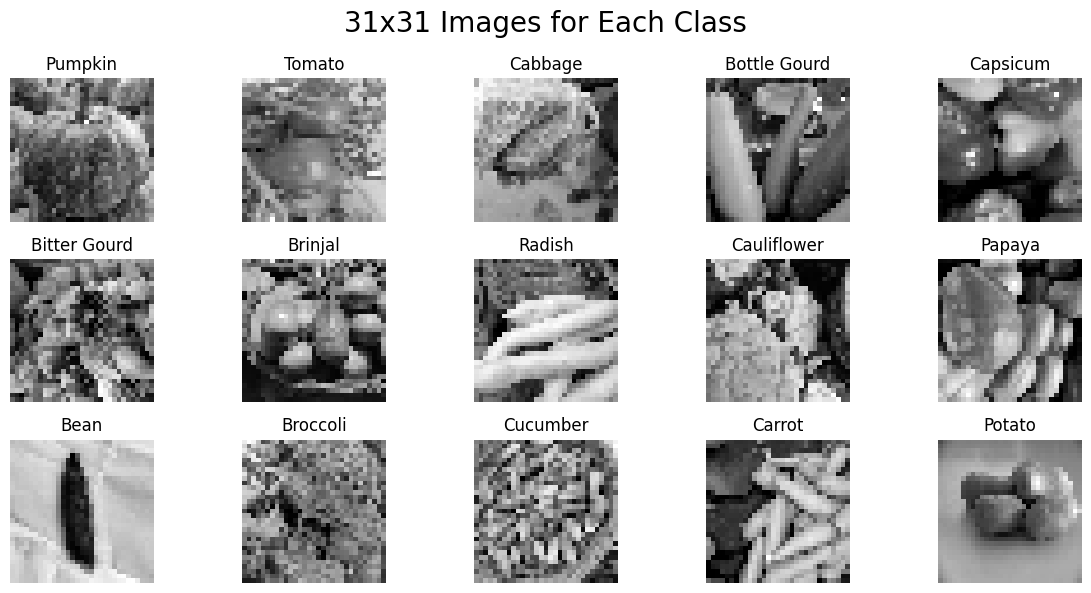

In [52]:
plot_unique_images(dataset_train_31, '31x31 Images for Each Class', class_labels)

Observations:
- We can hardly differentiate some images between classes for images of size 31x31(brocoli,bitter_gourd), hopefully our model can better differeniate these images better than humans!

Now lets get a wider sample range of pictures of every class, to see how diverse the classes are.

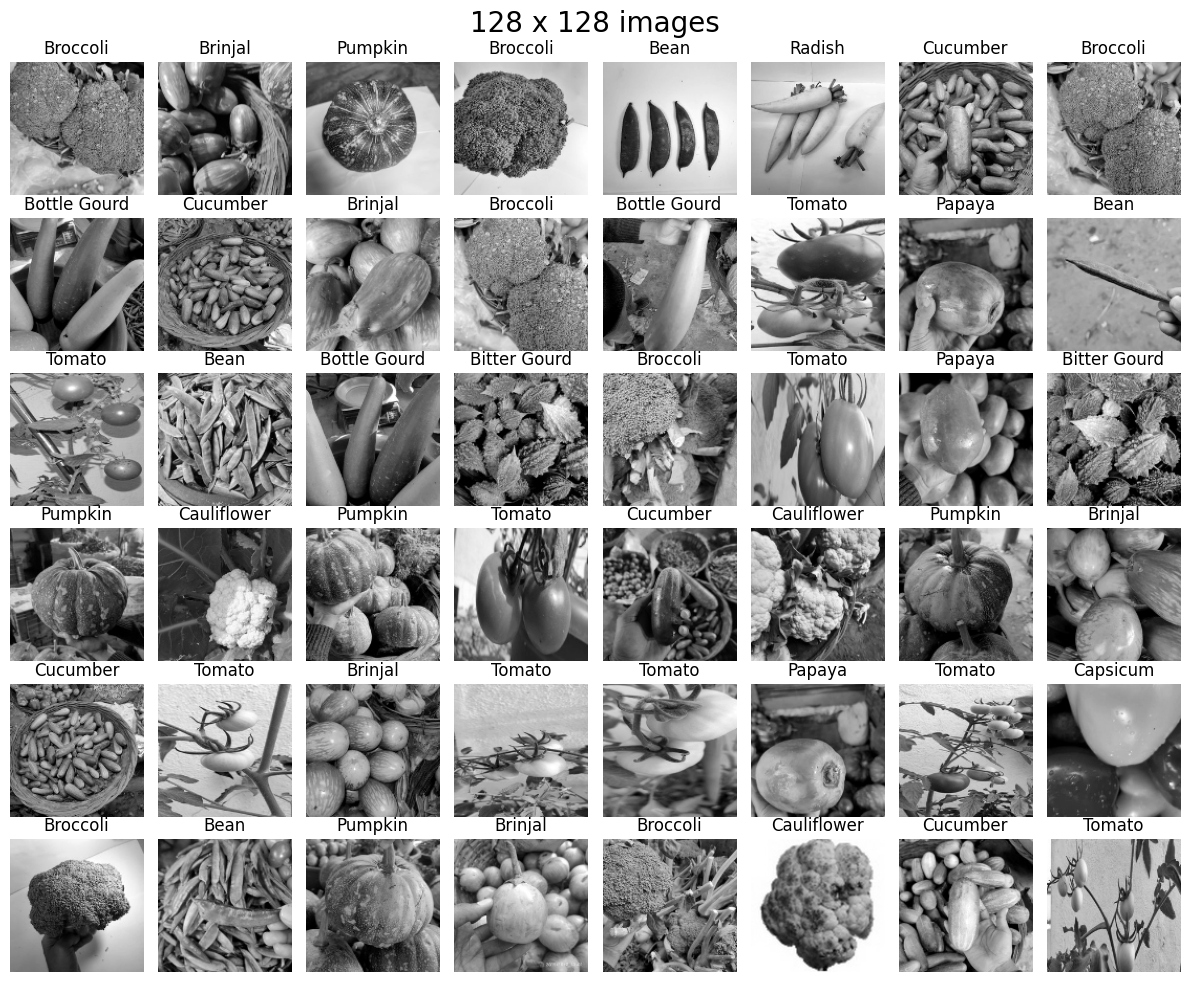

In [53]:
def plot_dataset_huge(amtOfImages, dataset,title,class_labels):
    plt.figure(figsize=(12, 10))
    plt.suptitle(title, fontsize=20)
    for images, labels in dataset.take(1):
        num_images = len(images)  

        row = int(np.sqrt(amtOfImages))
        col = int(np.ceil(amtOfImages / row))
            
        for i in range(min(amtOfImages, num_images)):
            ax = plt.subplot(row, col, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
            plt.title(class_labels[np.argmax(labels[i])])
            plt.axis("off")

    plt.subplots_adjust(wspace=0.1, hspace=0.01)
    plt.tight_layout()
    plt.show()

plot_dataset_huge(48,dataset_train_128,'128 x 128 images',class_labels)

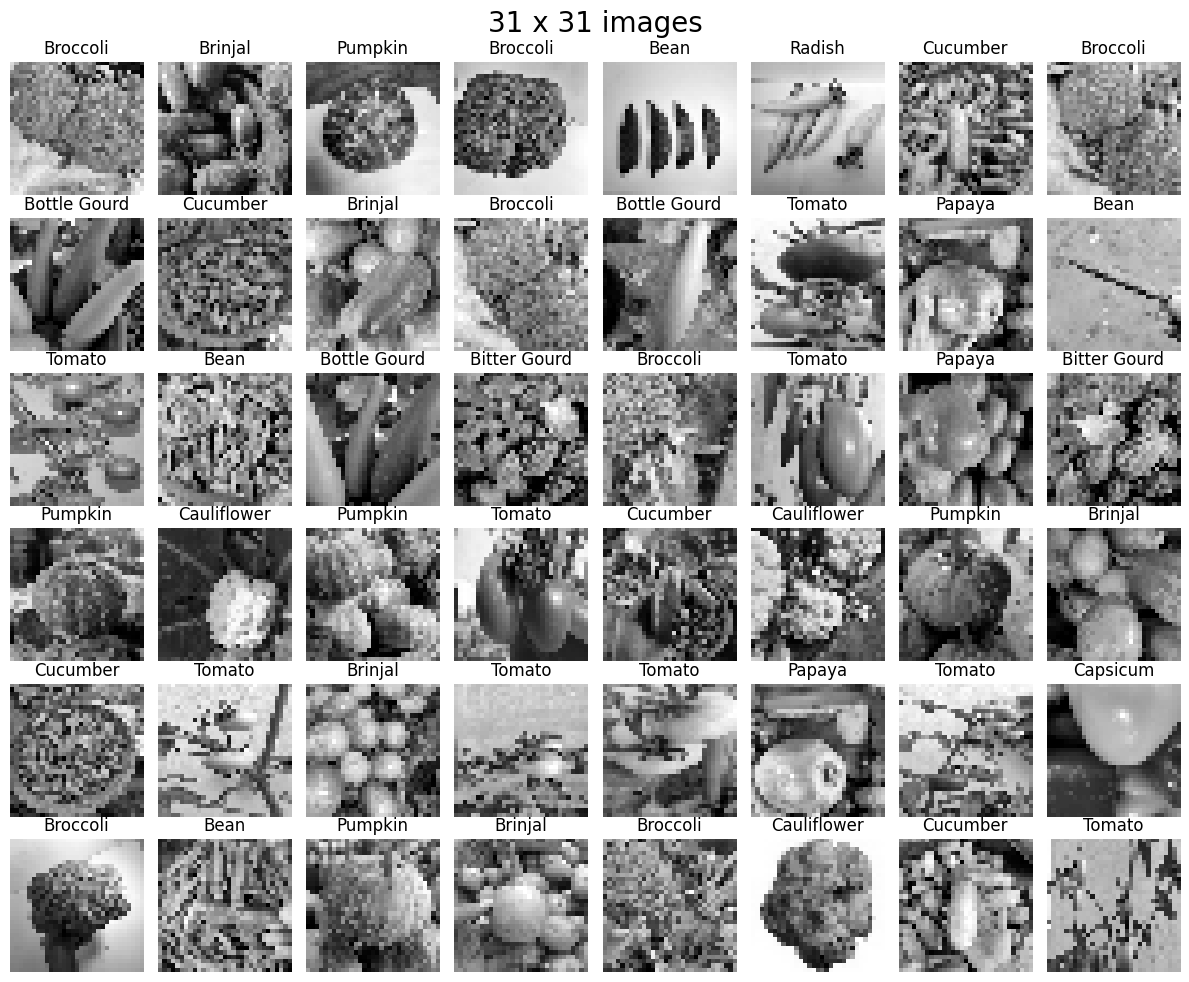

In [54]:
plot_dataset_huge(48,dataset_train_31,'31 x 31 images',class_labels)

Observations:
- Cauliflowers and Potatos are easily differentiable, with potatos usually having a white background and cauliflowers having 

### Class Distribution

In [55]:
class_counts_df = pd.DataFrame(columns=class_labels)

def count_classes(dataset, class_labels):
    class_count = {label: 0 for label in class_labels}
    for _, labels in dataset:
        for label in labels:
            class_name = class_labels[tf.argmax(label)]
            class_count[class_name] += 1
    return class_count

class_counts_df.loc['Validation'] = count_classes(dataset_validation_128, class_labels)
class_counts_df.loc['Training'] = count_classes(dataset_train_128, class_labels)
class_counts_df.loc['Test'] = count_classes(dataset_test_128, class_labels)
class_counts_df.loc['Total Classes'] = class_counts_df.sum()
class_counts_df['Total Datasets'] = class_counts_df.sum(axis=1)

class_counts_df

,Bean,Bitter Gourd,Bottle Gourd,Brinjal,Broccoli,Cabbage,Capsicum,Carrot,Cauliflower,Cucumber,Papaya,Potato,Pumpkin,Radish,Tomato,Total Datasets
Validation,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,3000
Training,780,720,441,868,750,503,351,256,587,812,566,377,814,248,955,9028
Test,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,3000
Total Classes,1180,1120,841,1268,1150,903,751,656,987,1212,966,777,1214,648,1355,15028


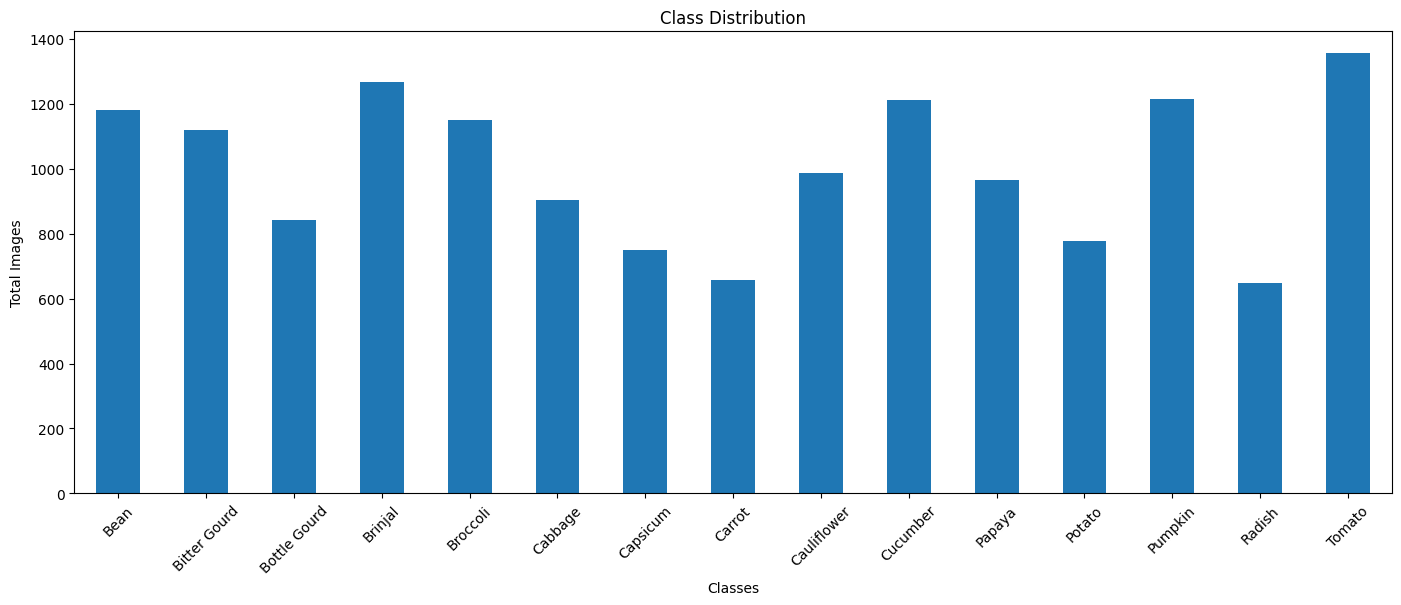

In [56]:
class_counts_df_plot = class_counts_df.drop(['Total Datasets'], axis=1)
class_counts_df_plot = class_counts_df_plot.T
class_counts_df_plot

# Plot the bar graph
class_counts_df_plot['Total Classes'].plot(kind='bar', figsize=(17, 6))
plt.xlabel('Classes')
plt.ylabel('Total Images')
plt.title('Class Distribution')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

We can see that we have an class imbalance for our train dataset. Oh No!! What should we do?
- There are quite alot of solutions for this problem, here are 3 main solutions:
    1. We can augment our data on the minority classes(Bottle_gourd, carrots and radish). However we want to also augment our other images classes to prevent overfitting so this is not a good option.
    2. We can oversample or undersample our minority or majority classes.However oversampling can lead to overfitting without any data augmentation.
    3. We can modify the loss function to assign different weights to each class, such as increasing the loss weigh for our minority class.


We will be assigning different weights for each class for a few reasons:
- It helps preserve our data....
- Prevents overfitting....
- Much simpler than Image oversampling...

In [57]:
class_counts_df_plot['Training'].values

array([780, 720, 441, 868, 750, 503, 351, 256, 587, 812, 566, 377, 814,
       248, 955], dtype=int64)

In [58]:
class_weights = tf.math.reciprocal(tf.constant(
(class_counts_df_plot['Training'].values).astype(np.float32)))

# Normalize the class weights
class_weights = class_weights / tf.reduce_sum(class_weights)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights.numpy())}

print("Class Weights:", class_weights_dict)

Class Weights: {0: 0.042979263, 1: 0.046560865, 2: 0.07601774, 3: 0.038621914, 4: 0.04469843, 5: 0.06664775, 6: 0.09550946, 7: 0.13095243, 8: 0.05711043, 9: 0.041285496, 10: 0.05922937, 11: 0.088922605, 12: 0.041184057, 13: 0.1351767, 14: 0.03510348}


Another important question to ask is. 
- What are our pixel distributions for our datasets? and what is the std and mean of them? 

In [59]:
def compute_statistics(dataset,title):
    pixel_min = float('inf') 
    pixel_max = float('-inf')
    pixel_sum = 0
    pixel_sum_square = 0
    num_pixels = 0

    for images, _ in dataset:
        for image in images:
            # Calculate min and max pixel values
            pixel_min = min(pixel_min, np.min(image))
            pixel_max = max(pixel_max, np.max(image))

            # Update sum and sum of squares for mean and std calculation
            pixel_sum += np.sum(image)
            pixel_sum_square += np.sum(image ** 2)
            num_pixels += np.prod(image.shape)

    # Calculate mean and std
    pixel_mean = pixel_sum / num_pixels
    pixel_std = np.sqrt((pixel_sum_square / num_pixels) - (pixel_mean ** 2))

    print(title)
    print("Min Pixel Value:", pixel_min)
    print("Max Pixel Value:", pixel_max)
    print("Mean Pixel Value:", pixel_mean)
    print("Standard Deviation:", pixel_std)

    return

compute_statistics(dataset_train_31,'Training Images')
compute_statistics(dataset_test_31,'Test Images')
compute_statistics(dataset_validation_31,'Validation Images')

Training Images
Min Pixel Value: 0.0
Max Pixel Value: 255.0
Mean Pixel Value: 114.34127948859215
Standard Deviation: 55.387912533676406
Test Images
Min Pixel Value: 0.0
Max Pixel Value: 255.0
Mean Pixel Value: 114.66371605098855
Standard Deviation: 55.07995207606749
Validation Images
Min Pixel Value: 0.0
Max Pixel Value: 255.0
Mean Pixel Value: 113.78344607803287
Standard Deviation: 55.49623592897191


- Our pixel values range from 0 to 255, which is expected as grayscale images typically have pixel values ranging from 0 (black) to 255 (white). 
- Our average pixel is around 114, which means that our images are not heavily skewed toward either very dark or very bright values.

### Image Averaging
We will be using only the test and validation datasets for averaging as the train set has class imbalance and may result in inaccurate results.

In [60]:
def calculate_mean_image(datasets, image_size, title):
    pixel_sum = np.zeros((image_size[0], image_size[1]), dtype=np.float64)
    num_images = 0
    mean_images = np.zeros((image_size[0], image_size[1]), dtype=np.float64)

    for dataset in datasets:
        for images, _ in dataset:
            for image in images:
                pixel_sum += np.squeeze(image, axis=-1)
                num_images += 1

    # Calculate the mean image
    mean_image = pixel_sum / num_images
    mean_images = mean_images + mean_image
    
    mean_images = mean_images / len(datasets)

    return mean_images

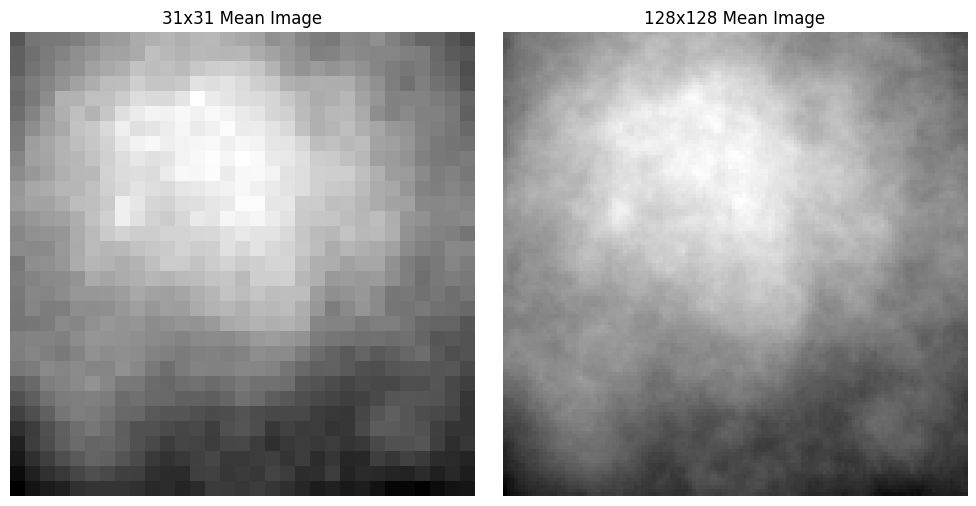

In [61]:
image_size_31 = (31, 31)
image_size_128 = (128, 128)

mean_image_31 = calculate_mean_image([dataset_test_31, dataset_validation_31], image_size_31, 'Average Mean Image (31x31)')
mean_image_128 = calculate_mean_image([dataset_test_128, dataset_validation_128], image_size_128, 'Average Mean Image (128x128)')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(mean_image_31, cmap='gray')
plt.title('31x31 Mean Image')
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(mean_image_128, cmap='gray')
plt.title('128x128 Mean Image')
plt.axis("off")
plt.tight_layout()
plt.show()

The mean image for all the images combined looks like a fog, and we cant really determine any of or classes from this average image.

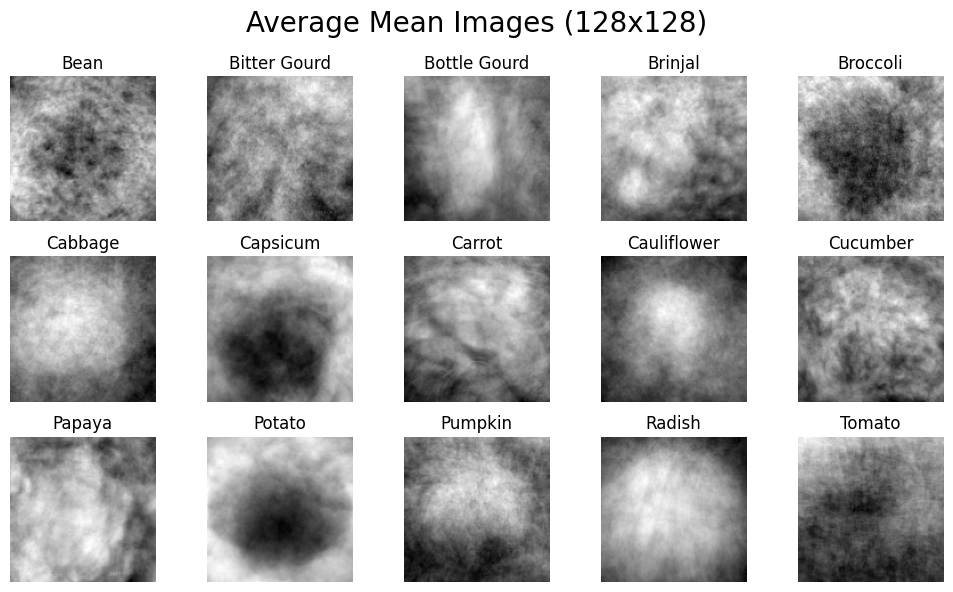

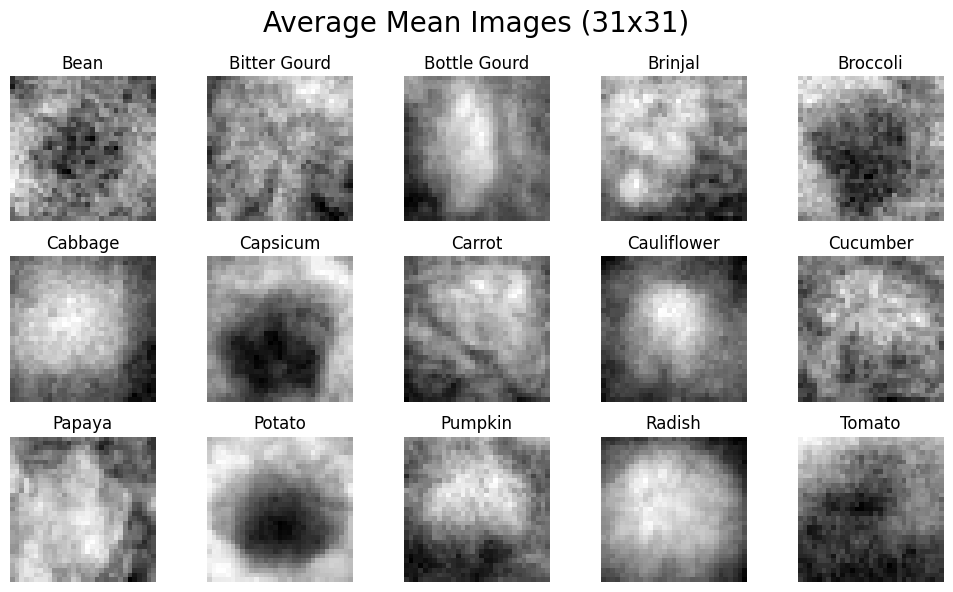

In [62]:
def calculate_class_mean_images(dataset, class_labels, image_size, title,amtOfImages=15):
    class_mean_images = {}  # To store the mean images for each class

    # Initialize mean images for each class
    for class_label in class_labels:
        class_mean_images[class_label] = np.zeros((image_size[0], image_size[1]), dtype=np.float64)

    num_images = 0

    for images, labels in dataset:
        for i, label in enumerate(labels):
            class_label = class_labels[np.argmax(label)]
            class_mean_images[class_label] += np.squeeze(images[i], axis=-1)
            num_images += 1

    num_images = amtOfImages
    row = int(np.sqrt(num_images))
    col = int(np.ceil(num_images / row))

    # Calculate and display the mean image for each class
    plt.figure(figsize=(10, 6))
    plt.suptitle(title, fontsize=20)

    for i, class_label in enumerate(class_labels):
        mean_image = class_mean_images[class_label] / (class_mean_images[class_label].max() + 1e-8)
        plt.subplot(row,col, i + 1)
        plt.imshow(mean_image, cmap='gray')
        plt.title(class_label)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

calculate_class_mean_images(dataset_test_128, class_labels, image_size_128, 'Average Mean Images (128x128)')
calculate_class_mean_images(dataset_test_31, class_labels, image_size_31, 'Average Mean Images (31x31)')

Observations:
- We can see that the pixels for different classes kind of group together to show where the vegetable is. For example, the average image for potato has a cluster of black pixels in the center, roughly outlining a potato.
- However as the images in the dataset are quite complicated, it is quite hard to differentiate out individual classes without labels.

## Data Preprocessing
We need to preprocess our data to help our models to converge faster ,ie lesser time to train. And helps the model to generalise better and prevent it from overfitting.

### Normalizing our images
__Why do we need to normalize our images?__

As normalizing involves scalling the pixel values of our images between 0 and 1 , this results in our images all having a similiar data distribution. Which makes our models benefit from faster convergence during gradient descent and generalising better.

Normalizing the inputs in our context involves calculating the mean and standard deviation of the training dataset and then applying the following formula to each input:
$$
X_{} = \frac{X_{} - μ_{}}{σ_{}}
$$

In [63]:
# use rescaling
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_dataset_train_31 = dataset_train_31.map(lambda x, y: (normalization_layer(x), y))

compute_statistics(normalized_dataset_train_31,'Normalised Training Images')

Normalised Training Images
Min Pixel Value: 0.0
Max Pixel Value: 1.0
Mean Pixel Value: 0.448397200505043
Standard Deviation: 0.21720750670021785


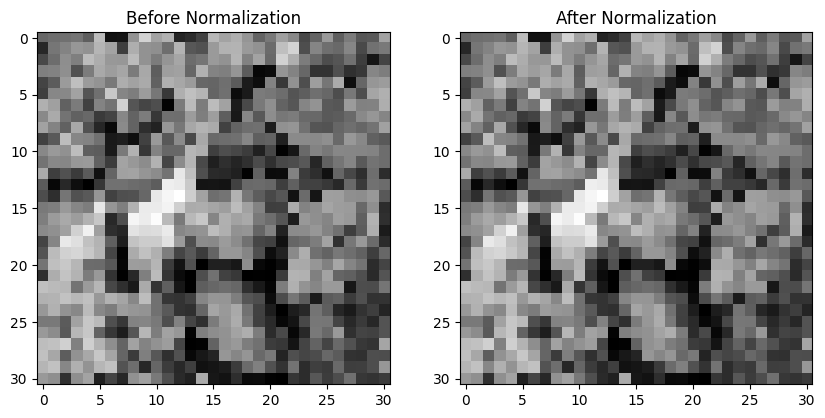

In [64]:
for images, labels in dataset_train_31.take(1):
    original_images = images

normalized_images = normalization_layer(original_images)

original_image = original_images[0]
normalized_image = normalized_images[0]

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

ax[0].imshow(original_image.numpy().squeeze(), cmap='gray')
ax[0].set_title('Before Normalization')

ax[1].imshow(normalized_image.numpy().squeeze(), cmap='gray')
ax[1].set_title('After Normalization')

plt.show()

Observations:
- We can see that.....

### Data Augementation
- use only on train data not test n validation
- flipping (horizontal/ vertically)
- zooming(maybe)
- rotating

use tf.keras.layers to augment images as it allows it to use gpu

In [109]:
#test
def augment_images(image,label):
    image = tf.map_fn(lambda img: tf.image.random_crop(img, size=[31, 31, 1]), image)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    # image = tf.keras.preprocessing.image.random_zoom(image)
    return image,label

In [110]:


model = Sequential()
model.add(tf.keras.layers.Rescaling(1./255, input_shape=(31, 31, 1)))
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(31, 31, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(15, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# train_generator = datagen.flow(dataset_train_31, batch_size=32)
train_generator = dataset_train_31.map(augment_images)

model.fit(train_generator, epochs=20, validation_data=dataset_test_31,class_weight=class_weights_dict)

TypeError: in user code:

    File "C:\Users\p2222668\AppData\Local\Temp\ipykernel_23880\2349902422.py", line 6, in augment_images  *
        image = tf.keras.preprocessing.image.random_zoom(image)

    TypeError: random_zoom() missing 1 required positional argument: 'zoom_range'


In [74]:
model = Sequential()
model.add(tf.keras.layers.Rescaling(1./255, input_shape=(31, 31, 1)))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Flatten())
model.add(Dense(15, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# datagen = ImageDataGenerator(
#         rotation_range=40,       # Rotate images randomly by up to 40 degrees
#         horizontal_flip=True,    # Randomly flip images horizontally
#         vertical_flip=True,      # Randomly flip images vertically
# )

# train_generator = datagen.flow_from_directory(
#         directory_train,
#         target_size=(31, 31),
#         color_mode="grayscale",
#         batch_size=128,
#         class_mode='categorical')

model.fit(dataset_train_31, epochs=20, validation_data=dataset_test_31,class_weight=class_weights_dict)

Found 9028 images belonging to 15 classes.
Epoch 1/20
71/71 [==============================] - 4s 40ms/step - loss: 0.1409 - accuracy: 0.2065 - val_loss: 2.2294 - val_accuracy: 0.3000
Epoch 2/20
71/71 [==============================] - 3s 38ms/step - loss: 0.1158 - accuracy: 0.3779 - val_loss: 1.9879 - val_accuracy: 0.3943
Epoch 3/20
71/71 [==============================] - 3s 38ms/step - loss: 0.1002 - accuracy: 0.4711 - val_loss: 1.8563 - val_accuracy: 0.4290
Epoch 4/20
71/71 [==============================] - 3s 38ms/step - loss: 0.0892 - accuracy: 0.5340 - val_loss: 1.7762 - val_accuracy: 0.4727
Epoch 5/20
71/71 [==============================] - 3s 38ms/step - loss: 0.0802 - accuracy: 0.5812 - val_loss: 1.7436 - val_accuracy: 0.4827
Epoch 6/20
71/71 [==============================] - 3s 38ms/step - loss: 0.0721 - accuracy: 0.6198 - val_loss: 1.7837 - val_accuracy: 0.4750
Epoch 7/20
71/71 [==============================] - 3s 38ms/step - loss: 0.0653 - accuracy: 0.6568 - val_loss: 

In [76]:
model = Sequential()
model.add(tf.keras.layers.Rescaling(1./255, input_shape=(31, 31, 1)))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Flatten())
model.add(Dense(15, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(dataset_train_31, epochs=20, validation_data=dataset_test_31,class_weight=class_weights_dict,batch_size=32)

Epoch 1/20
71/71 [==============================] - 3s 39ms/step - loss: 0.1393 - accuracy: 0.2180 - val_loss: 2.2225 - val_accuracy: 0.2990
Epoch 2/20
71/71 [==============================] - 3s 37ms/step - loss: 0.1140 - accuracy: 0.3912 - val_loss: 1.9855 - val_accuracy: 0.3887
Epoch 3/20
71/71 [==============================] - 3s 38ms/step - loss: 0.0976 - accuracy: 0.4928 - val_loss: 1.8136 - val_accuracy: 0.4597
Epoch 4/20
71/71 [==============================] - 3s 37ms/step - loss: 0.0860 - accuracy: 0.5513 - val_loss: 1.7858 - val_accuracy: 0.4607
Epoch 5/20
71/71 [==============================] - 3s 37ms/step - loss: 0.0753 - accuracy: 0.6039 - val_loss: 1.7374 - val_accuracy: 0.4793
Epoch 6/20
71/71 [==============================] - 3s 38ms/step - loss: 0.0658 - accuracy: 0.6509 - val_loss: 1.7416 - val_accuracy: 0.4967
Epoch 7/20
71/71 [==============================] - 3s 38ms/step - loss: 0.0581 - accuracy: 0.6863 - val_loss: 1.8578 - val_accuracy: 0.4840
Epoch 8/20
71

KeyboardInterrupt: 

## Models
- compare between augmented/ non-augmented images
- Base
- custom model resnet
- custom vg16
- need research more

## Hyperparemeter Tuning

## Final Model